<a href="https://colab.research.google.com/github/supuni9622/Test-Google-Colab/blob/main/Lyrics_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd /content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/NLP

/content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/NLP


# Import Libraries

In [3]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
!pip install stanza
import stanza
import re

import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils


import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")

import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
!pip install fasttext
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

0it [00:00, ?it/s]


# Parameters

In [4]:
TEXT = "Chorus"
LABEL = "Emotion"

# List of models

In [5]:
lang                   = False
sample                 = True
part_of_speech         = False
multinomial_naive_bayes= True
logistic_regression    = True
svm_model              = True
k_nn_model             = True
sgd                    = True
random_forest          = True
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_nn                = True
rnn                    = True
lstm                   = True
cnn                    = True
gru                    = True
cnn_lstm               = True
cnn_gru                = True
bidirectional_rnn      = True
bidirectional_lstm     = True
bidirectional_gru      = True
rcnn                   = True
pre_trained            = False

# Import data

In [6]:
dataset = pd.read_csv('Lyrical_data_5.csv',encoding='cp1252')

In [7]:
dataset.dropna(how='all', axis=1, inplace=True)

In [8]:
print (dataset.isnull().sum())

Song_ID       0
Song_Title    0
Chorus        0
Emotion       0
dtype: int64


In [9]:
modifiedDF = dataset.dropna()

In [10]:
modifiedDF['Chorus'].apply(lambda x: len(x.split(' '))).sum()
#We have 42,081 words in data

42081

In [11]:
from numpy import random
import gensim
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

modifiedDF = modifiedDF.reset_index(drop=True)
REPLACE = re.compile('[^a-zA-Z]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE.sub(' ', text)
    #text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
modifiedDF['Chorus'] = modifiedDF['Chorus'].apply(clean_text)

# Preprocessing

Polarity

The sentiment function of textblob returns two properties, polarity, and subjectivity. Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement

In [13]:
# ---- Polarity estimation with TextBlob
modifiedDF['polarity'] = modifiedDF[TEXT].map(lambda text: TextBlob(text).sentiment.polarity)

Text(0, 0.5, 'Number of text')

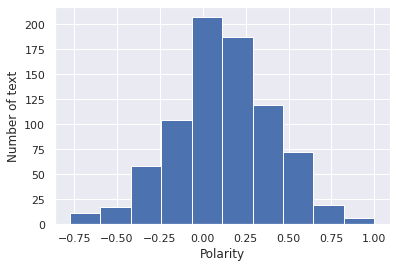

In [14]:
# ---- Show the polarities repartition
modifiedDF['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of text")
#plt.savefig("polarity.png")

Text Informations

In [15]:
# ---- Extract statistics of the text 
modifiedDF['char_count'] = modifiedDF[TEXT].apply(len) # Number of characters in the string
modifiedDF['word_count'] = modifiedDF[TEXT].apply(lambda x: len(x.split())) # Number of words in the string 
modifiedDF['word_density'] = modifiedDF['char_count'] / (modifiedDF['word_count']+1) # Density of word (in char)
#df['punctuation_count'] = df[TEXT].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
modifiedDF['title_word_count'] = modifiedDF[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
#df['upper_case_word_count'] = df[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [16]:
modifiedDF.head(2)

,Song_ID,Song_Title,Chorus,Emotion,polarity,char_count,word_count,word_density,title_word_count
0,1,Diana,diana let one light fire inside eyes lonely ev...,Inspiration,0.033333,136,25,5.230769,0
1,2,Don't forget where you belong,forget belong home forget belong home ever fee...,Inspiration,0.000000,70,12,5.384615,0


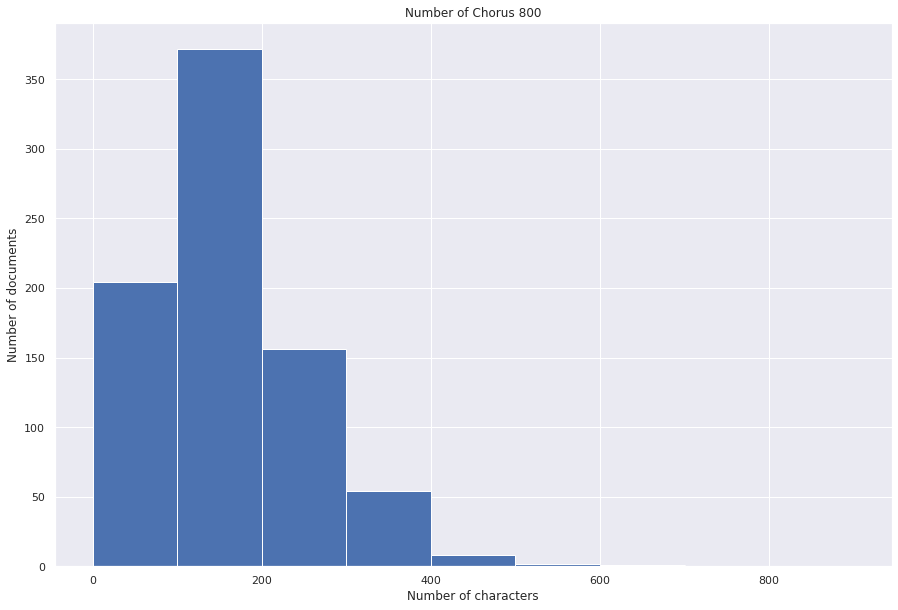

<Figure size 432x288 with 0 Axes>

In [17]:
# ---- Show the number of characters per document
plt.figure(figsize=(15,10))
max_x = 1000 if modifiedDF.char_count.max()>1000 else modifiedDF.char_count.max()
plt.hist(modifiedDF.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Number of {TEXT} {modifiedDF.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()
plt.savefig("numb_char.png")

Classes repartition

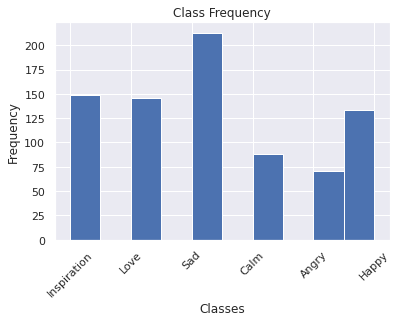

In [18]:
# ---- histogram of the class frequency
modifiedDF[LABEL].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")
plt.savefig("distrib_classes.png")

# N-Grams

Uni-grams

In [19]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation
corpus = []
for i in range(0, 799):
  Lyrics = re.sub('[^a-zA-Z]', ' ', modifiedDF['Chorus'][i])
  Lyrics = re.sub("\\r", " ", modifiedDF['Chorus'][i])
  Lyrics = re.sub("\,", " ", Lyrics)
  Lyrics = re.sub("\'s", " ", Lyrics) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
  Lyrics = re.sub(" whats ", " what is ", Lyrics, flags=re.IGNORECASE)
  Lyrics = re.sub("\'ve", " have ", Lyrics)
  Lyrics = re.sub("can't", "can not", Lyrics)
  Lyrics = re.sub("n't", " not ", Lyrics)
  Lyrics = re.sub("i'm", "i am", Lyrics, flags=re.IGNORECASE)
  Lyrics = re.sub("\'re", " are ", Lyrics)
  Lyrics = re.sub("\'d", " would ", Lyrics)
  Lyrics = re.sub("\'ll", " will ", Lyrics)
  Lyrics = re.sub("e\.g\.", " eg ", Lyrics, flags=re.IGNORECASE)
  Lyrics = re.sub("b\.g\.", " bg ", Lyrics, flags=re.IGNORECASE)
  Lyrics = Lyrics.lower()
  Lyrics = Lyrics.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  all_stopwords.remove('down')
  all_stopwords.remove("y")
  all_stopwords.remove("i")
  all_stopwords.remove('over')
  all_stopwords.remove('under')
  all_stopwords.remove('no')
  all_stopwords.remove('only')
  all_stopwords.remove("don't")
  all_stopwords.remove("aren't")
  all_stopwords.remove("o")
  all_stopwords.remove("ma")
  all_stopwords.remove("didn't")
  all_stopwords.remove("can")
  all_stopwords.remove("be")
  all_stopwords.remove("to")
  all_stopwords.remove("for")
  all_stopwords.remove("you")
  all_stopwords.remove("your")
  all_stopwords.remove("we")
  all_stopwords.remove("our")
  all_stopwords.remove("my")
  all_stopwords.remove("you're")
  Lyrics = [ps.stem(word) for word in Lyrics if not word in set(all_stopwords)]
  Lyrics = ' '.join(Lyrics)
  #Lyrics = [c for c in Lyrics if c not in punctuation]
  #Lyrics = ' '.join(Lyrics)
  corpus.append(Lyrics)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]

     Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [21]:
common_words_before = get_top_n_words(modifiedDF['Chorus'], 20)
for word, freq in common_words_before:
    print(word, freq)

love 437
know 322
like 276
let 204
go 194
never 184
oh 183
get 179
baby 176
time 169
one 165
say 160
need 157
wanna 157
got 156
cause 155
see 153
want 146
heart 144
yeah 142


In [22]:
df1 = pd.DataFrame(common_words_before, columns = ['words' , 'count'])

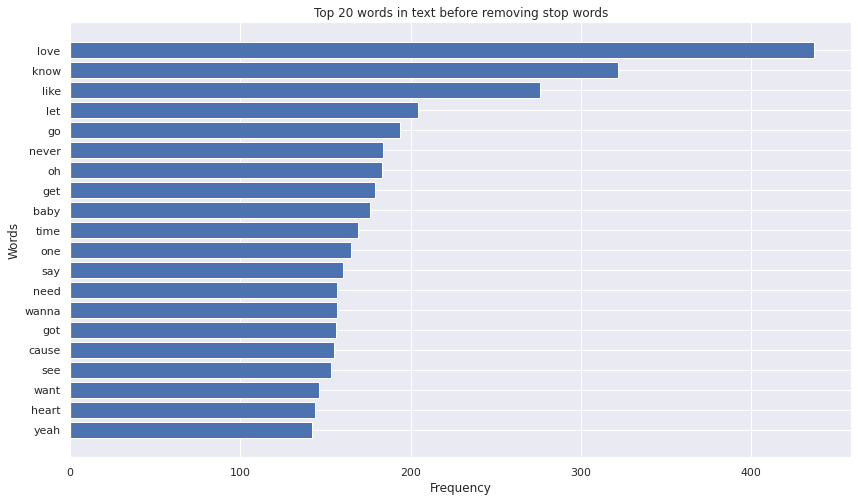

In [23]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df1["words"][::-1], df1["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

In [24]:
common_words = get_top_n_words(corpus, 20)
for word, freq in common_words:
    print(word, freq)

love 485
know 339
like 278
feel 230
go 223
let 212
get 206
want 186
never 184
oh 183
time 182
come 177
say 174
babi 173
one 171
need 165
see 159
caus 157
wanna 157
got 156


In [25]:
df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

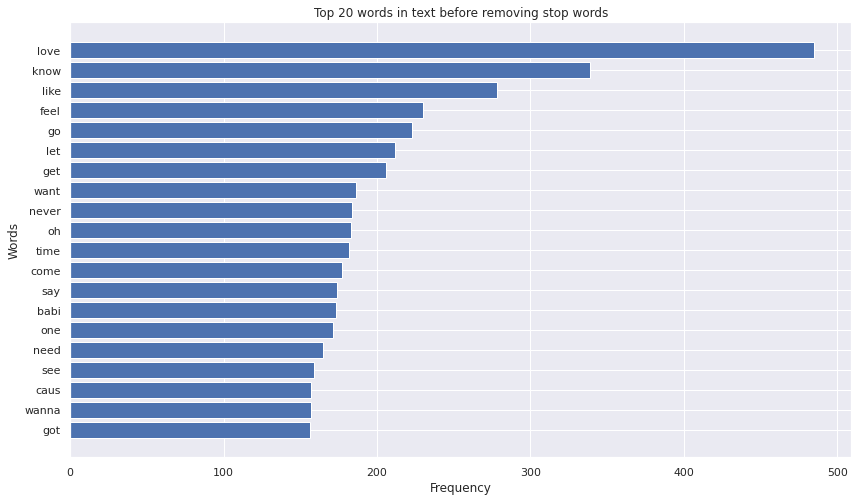

In [26]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df2["words"][::-1], df2["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

Bi-grams

In [27]:
def get_top_n_bigram(corpus, n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) 
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [28]:
number = 20
common_words_bi_gram_before = get_top_n_bigram(modifiedDF[TEXT], number)

In [29]:
df3 = pd.DataFrame(common_words_bi_gram_before, columns = ['words' , 'count'])

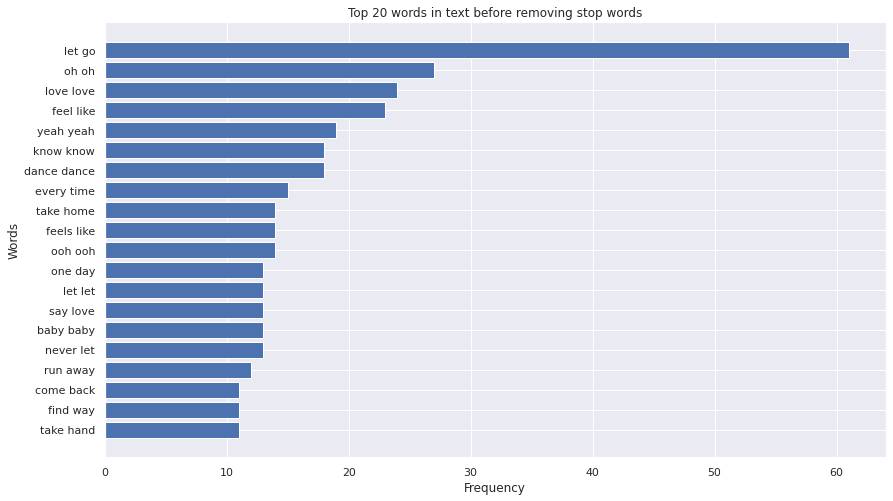

In [30]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df3["words"][::-1], df3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

In [31]:
common_words_bi_gram = get_top_n_bigram(corpus, number)

In [32]:
df4 = pd.DataFrame(common_words_bi_gram, columns = ['words' , 'count'])

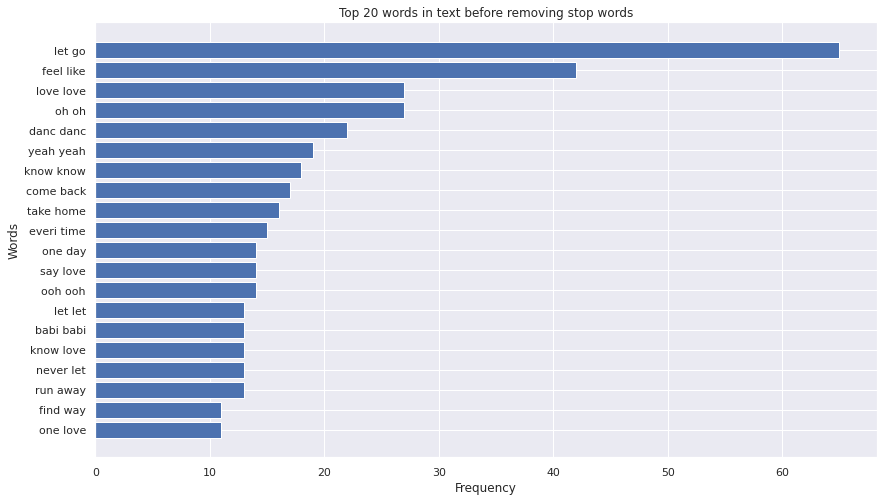

In [33]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df4["words"][::-1], df4["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

Tri-grams

In [34]:
 def get_top_n_trigram(corpus, n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [35]:
number = 20
common_words_tri_gram_before = get_top_n_trigram(modifiedDF[TEXT], number)

In [36]:
df5 = pd.DataFrame(common_words_tri_gram_before, columns = ['words' , 'count'])

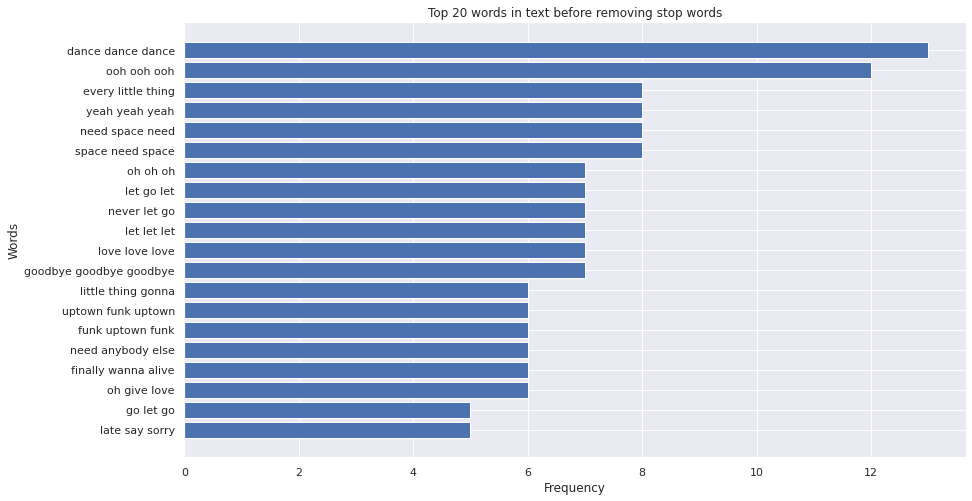

In [37]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df5["words"][::-1], df5["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

In [38]:
common_words_tri_gram = get_top_n_trigram(corpus, number)

In [39]:
df6 = pd.DataFrame(common_words_tri_gram, columns = ['words' , 'count'])

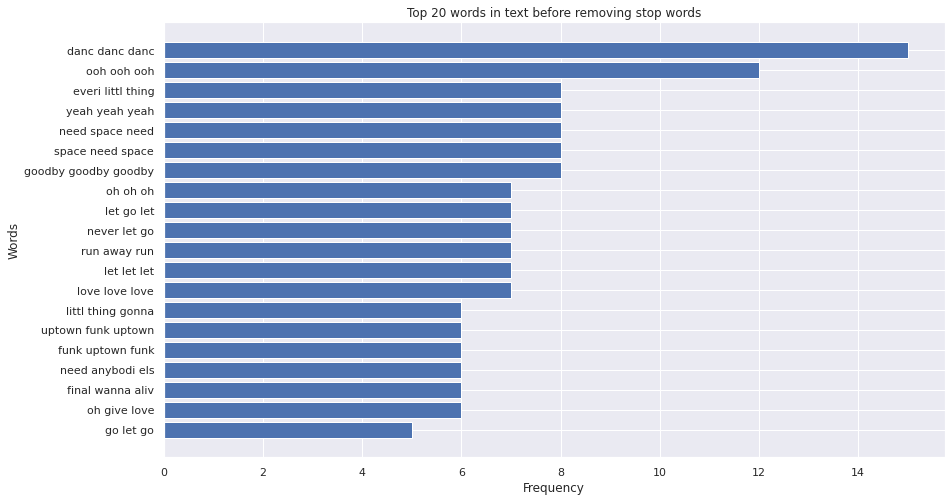

In [40]:
number = 20
plt.figure(figsize=(14,8))
plt.barh(df6["words"][::-1], df6["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

# Part-of-Speech Tagging (POS)

In [41]:
def pos_ner_lemma(df, column, lang="en"):
    '''
    Function to do part-of-speech with stanza librairy. The pipeline is configured to 
    tokenize, mwt, pos, lemma, ner parameters, it will does part-of-speech, lemmatized words
    and name entity recognition.
    @param df: (pandas.dataframe) dataframe containing the data
    @param column: (str) name of the column containing text
    @param lang: (str) language of the text
    '''
    print("Building an French pipeline...")
    nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,ner") # creation of the pipeline
    text_lem = []
    text_pos = []
    text_ner = []
    for i in tqdm(df[column]): # loop on each text 
        doc = nlp(i) # fit the text with the pipeline 
        try:
            text_lem.append(' '.join([word.lemma for sent in doc.sentences for word in sent.words])) # lemmatize 
        except: # if 
            text_lem.append('') 
        try:
            text_pos.append(' '.join([f'word: {word.text} upos: {word.upos} xpos: {word.xpos} feats: \
            {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words])) # pos 
        except:
            text_pos.append('')
        try:
            text_ner.append(' '.join([f'token: {token.text} ner: {token.ner}' for sent in doc.sentences for token in sent.tokens])) # NER
        except:
            text_ner.append('')
            
    df.loc[:,column+"_lemma"] = text_lem
    df.loc[:,column+"_pos"] = text_pos
    df.loc[:,column+"_ner"] = text_ner
    
    return df

In [42]:
if part_of_speech:
    modifiedDF = pos_ner_lemma(modifiedDF, TEXT, lang='en')

# Machine Learning

In [102]:
import tensorflow as tf
def remove_stop_words(x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new =  tf.keras.preprocessing.text.text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [104]:

modifiedDF.loc[:,TEXT+"_sw"] = modifiedDF.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, all_stopwords))

100%|██████████| 800/800 [00:00<00:00, 4995.91it/s]


In [105]:
if modifiedDF[TEXT+"_sw"].isnull().sum()>0:
    print("Empty text")
    modifiedDF[TEXT+"_sw"][modifiedDF[TEXT+"_sw"].isnull()] = "empty_text"

In [107]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(modifiedDF[TEXT+"_sw"], modifiedDF[LABEL], random_state=42, stratify=modifiedDF[LABEL], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(modifiedDF[TEXT], modifiedDF[LABEL], random_state=42, stratify=modifiedDF[LABEL], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

Classes Weights

In [109]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                  y = y_train)

In [110]:
class_weights = dict(zip(np.unique(y_train), class_weights)),
class_weights

({'Angry': 1.871345029239766,
  'Calm': 1.5023474178403755,
  'Happy': 1.0062893081761006,
  'Inspiration': 0.896358543417367,
  'Love': 0.9116809116809117,
  'Sad': 0.6274509803921569},)

In [111]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(modifiedDF.Emotion.value_counts()) / np.max(modifiedDF.Emotion.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.333)


Save unique labels

In [112]:
# Keep the unique label corresponding to their encoding correspondance
labels = modifiedDF[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==6:
    labels = ["Angry", "Calm", "Happy", "Inspiration","Love","Sad"]

In [48]:
test, labels

(        labels encoding
 4        Angry        0
 3         Calm        1
 5        Happy        2
 0  Inspiration        3
 1         Love        4
 2          Sad        5,
 ['Angry', 'Calm', 'Happy', 'Inspiration', 'Love', 'Sad'])

One Hot Encording

In [113]:

%%time
# create a One-Hot encoding object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(modifiedDF[TEXT])

# transform the training and validation data 
# xtrain_count =  count_vect.transform(train_x)
# xvalid_count =  count_vect.transform(valid_x)
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: user 74.3 ms, sys: 0 ns, total: 74.3 ms
Wall time: 76.4 ms


TF-IDF

In [114]:

# %%time
# # word level tf-idf
# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect.fit(modifiedDF[TEXT])
# xtrain_tfidf =  tfidf_vect.transform(train_x)
# xvalid_tfidf =  tfidf_vect.transform(valid_x)
# print("word level tf-idf done")
# # ngram level tf-idf 
# tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
# tfidf_vect_ngram.fit(modifiedDF[TEXT])
# xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
# xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
# print("ngram level tf-idf done")
# # characters level tf-idf
# tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
# tfidf_vect_ngram_chars.fit(modifiedDF[TEXT])
# xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
# xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 
# print("characters level tf-idf done")

%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(modifiedDF[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(modifiedDF[TEXT])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(modifiedDF[TEXT])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 1.15 s, sys: 101 ms, total: 1.25 s
Wall time: 2.98 s


Load Pre-Trained model fastText

In [51]:
%%time

# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
# !unzip crawl-300d-2M-subword.zip
pretrained = fasttext.FastText.load_model('crawl-300d-2M-subword.bin')

CPU times: user 5.22 s, sys: 9.91 s, total: 15.1 s
Wall time: 2min 49s


Word Embeddings

In [52]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(modifiedDF[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 3507/3507 [00:00<00:00, 42303.71it/s]

CPU times: user 130 ms, sys: 16.3 ms, total: 146 ms
Wall time: 214 ms


#Naive Bayes

In [53]:
def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import seaborn as sns

In [55]:
def roc_auc_curve(model, x, y, labels, gb=False):
        '''
        Function to plot the ROC AUC curves for binary or multiclass classification. 
        Correct for standard machine learning models and Neural Networks. 
        @param model: (model) classification model
        @param x: (list) validation sample
        @param y: (list int) validation sample label
        @param gb: (bool) inform if the model is an ensemble model 
        '''
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(y.reshape(-1, 1)))]
        # predict probabilities
        if gb: # test if ensemble model 
            lr_probs = model.predict_proba(x)
        else:    
            lr_probs = model.predict(x)
        
        plt.figure(figsize=(10,8))
        if len(labels)==2: # binary classification 
            if gb:
                # compute area under the roc curve
                lr_auc = roc_auc_score(y, lr_probs[:,1], average="weighted")
            else:
                lr_auc = roc_auc_score(y, lr_probs, average="weighted")
            # Compute no skill roc curve 
            ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
            # plot the curve no skill
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            if gb: # test if the model is an ensemble model
                # compute ROC curve
                lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs[:,1])
            else:
                # compute ROC curve
                lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

            # plot the roc curve for the model
            plt.plot(lr_fpr, lr_tpr, label=f'Class (area {round(lr_auc,3)})')
                # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
                # show the grid
            plt.grid(True)
                # show the legend
            plt.legend()
        else: # multilabel classification 
            dummy_y = np_utils.to_categorical(y)
            #ns_auc = roc_auc_score(valid_y, dummy_ns, average="weighted", multi_class="ovr")

            lr_auc_multi = []
            for i in enumerate(labels):
                lr_auc_multi.append(round(roc_auc_score(dummy_y[:,i[0]], lr_probs[:,i[0]], average="weighted"),3))
                print(f"ROC AUC class {i[1]}: {lr_auc_multi[-1]}")
            lr_auc = roc_auc_score(dummy_y, lr_probs, average="weighted", multi_class="ovr" )

            ns_fpr, ns_tpr = [i/10 for i in list(range(0, 11, 1))], [i/10 for i in list(range(0, 11, 1))] #f(range(0, 0.1, 1))
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            for i in range(lr_probs.shape[1]):
                lr_fpr, lr_tpr, _ = roc_curve(dummy_y[:,i], lr_probs[:,i])
                # plot the roc curve for the model
                plt.plot(lr_fpr, lr_tpr, label=f'Class {labels[i]} (area {lr_auc_multi[i]})')
                # axis labels
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                # show the grid
                plt.grid(True)
                # show the legend
                plt.legend()
                
        print('\nROC AUC=%.3f \n' % (lr_auc))
        plt.show()

In [56]:
def precision_recall_curve(model, x, y, labels, gb=False):
        '''
        Function to plot the recall precision curves for binary or multiclass classification. 
        Correct for standard machine learning models and Neural Networks. 
        @param model: (model) classification model
        @param x: (list) validation sample
        @param y: (list int) validation sample label
        @param gb: (bool) inform if the model is an ensemble model 
        '''
        # predict probabilities
        if gb: # test if the model is an ensemble model 
            lr_probs = model.predict_proba(x)
        else:
            lr_probs = model.predict(x)

        print("\n")
        plt.figure(figsize=(10,8))

        if len(labels)==2: # binary classification 
            if gb:
                precision, recall, thresholds = precision_recall_curve(y, lr_probs[:,1]) # compute precision recall curve 
                lr_f1 = f1_score(y,(lr_probs[:,1]>0.5).astype(int))
            else:
                precision, recall, thresholds = precision_recall_curve(y, lr_probs)
                lr_f1 = f1_score(y,(lr_probs>0.5).astype(int))
            
            # calculate precision-recall AUC
            lr_auc = auc(recall, precision)
            # summarize scores
            print('Model: f1-score=%.3f AUC=%.3f' % (lr_f1, lr_auc)) # print f1-score and auc 
            plt.plot(recall, precision, marker='.', label='Model')
            no_skill = len(y[y==1]) / len(y)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        else:
            dummy_y = np_utils.to_categorical(y)
            dummy_lr = np_utils.to_categorical(lr_probs.argmax(-1))
            for i in enumerate(labels):
                precision, recall, thresholds = precision_recall_curve(dummy_y[:,i[0]], lr_probs[:,i[0]])
                # calculate precision-recall AUC
                lr_f1 = f1_score(dummy_y[:,i[0]], dummy_lr[:,i[0]]) 
                lr_auc = auc(recall, precision)
                # summarize scores
                print('Model class: %s --> f1-score=%.3f AUC=%.3f' % (i[1], lr_f1, lr_auc))
                plt.plot(recall, precision, label='Class %s' %(i[1]))
            no_skill = len(y[y>=1]) / len(y)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        # plot the precision-recall curves
        print("\n")

        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        # show the legend
        plt.legend()
        # show the grid
        plt.grid(True)
        # show the plot
        plt.show()

In [59]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
        '''
        Function to generate an heatmap of the confusion matrix
        @param cm: (matrix) confusion matrix
        @param classes: (list) list containing labels of the classes
        @param normalised: (bool) determined if the confusion matrix need to be normalized
        @param cmap: (str) color for the confusion matrix
        '''
        plt.figure(figsize=[10, 8])
        norm_cm = cm
        if normalized:
            norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
            #plt.savefig('confusion-matrix.png')

In [64]:
def metrics_ML(clf, X, Y, X_test, Y_test, gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=labels))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    # print("\n")
    # precision_recall_curve(model_, X_test, Y_test, labels, gb=gb)
    # print("\n")
    # roc_auc_curve(model_,  X_test, Y_test, labels, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")


Multinomial Naive Bayes for One-Hot encoding

Execution time : 0.004 s
Score : 53.75 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.67      0.29      0.40        14
        Calm       0.80      0.24      0.36        17
       Happy       0.88      0.56      0.68        27
 Inspiration       0.36      0.27      0.31        30
        Love       0.51      0.72      0.60        29
         Sad       0.49      0.79      0.61        43

    accuracy                           0.54       160
   macro avg       0.62      0.48      0.49       160
weighted avg       0.59      0.54      0.52       160


Confusion Matrix



Cohen's kappa: 41.26%




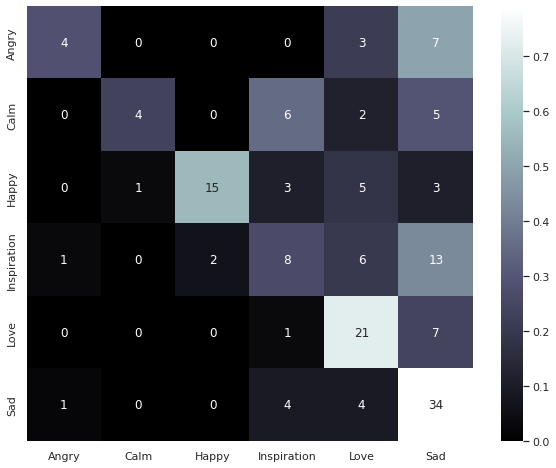

In [115]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for One-Hot encoding\n")
    metrics_ML(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Multinomial Naive Bayes for TF-IDF

Execution time : 0.006 s
Score : 33.12 %

Classification Report

              precision    recall  f1-score   support

       Angry       1.00      0.07      0.13        14
        Calm       0.00      0.00      0.00        17
       Happy       1.00      0.22      0.36        27
 Inspiration       0.40      0.07      0.11        30
        Love       0.57      0.14      0.22        29
         Sad       0.28      0.93      0.43        43

    accuracy                           0.33       160
   macro avg       0.54      0.24      0.21       160
weighted avg       0.51      0.33      0.25       160


Confusion Matrix



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Cohen's kappa: 9.93%




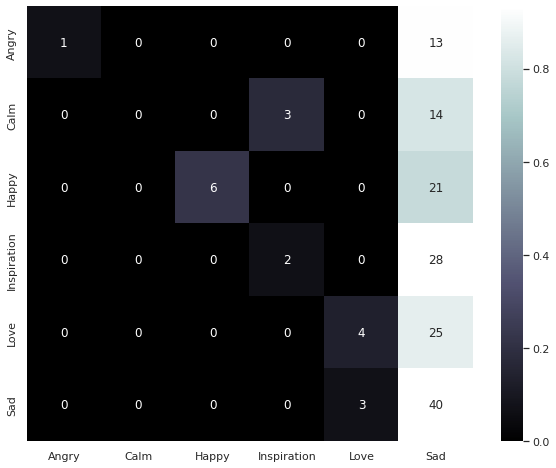

In [66]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF n-grams

Execution time : 0.005 s
Score : 31.25 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.00      0.00      0.00        17
       Happy       1.00      0.19      0.31        27
 Inspiration       0.62      0.17      0.26        30
        Love       0.00      0.00      0.00        29
         Sad       0.28      0.93      0.43        43

    accuracy                           0.31       160
   macro avg       0.32      0.21      0.17       160
weighted avg       0.36      0.31      0.22       160


Confusion Matrix



Cohen's kappa: 7.17%




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


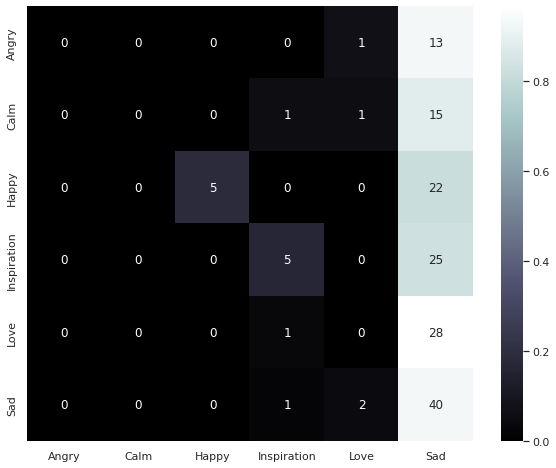

In [67]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF char n-grams

Execution time : 0.007 s
Score : 29.38 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.00      0.00      0.00        17
       Happy       1.00      0.19      0.31        27
 Inspiration       0.00      0.00      0.00        30
        Love       0.00      0.00      0.00        29
         Sad       0.27      0.98      0.43        43

    accuracy                           0.29       160
   macro avg       0.21      0.19      0.12       160
weighted avg       0.24      0.29      0.17       160


Confusion Matrix



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Cohen's kappa: 3.9%




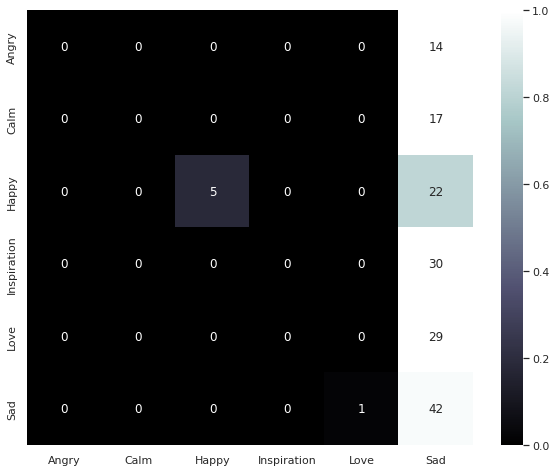

In [68]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF char n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

#Logistic Regression


Logistic Regression for One-Hot encoding

Execution time : 1.179 s
Score : 58.75 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.57      0.29      0.38        14
        Calm       0.46      0.35      0.40        17
       Happy       0.79      0.56      0.65        27
 Inspiration       0.57      0.43      0.49        30
        Love       0.62      0.79      0.70        29
         Sad       0.54      0.77      0.63        43

    accuracy                           0.59       160
   macro avg       0.59      0.53      0.54       160
weighted avg       0.60      0.59      0.57       160


Confusion Matrix



Cohen's kappa: 48.19%




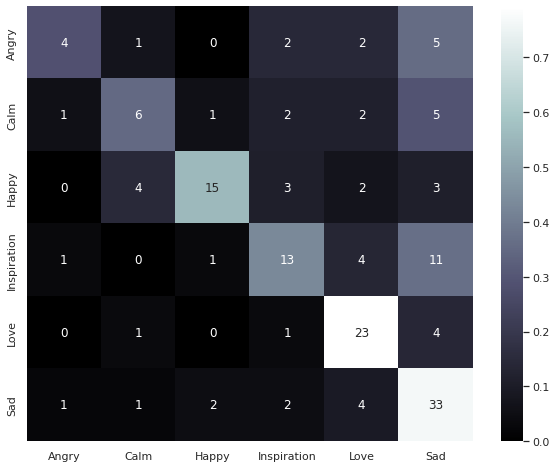

In [69]:
if logistic_regression:
    print("\nLogistic Regression for One-Hot encoding\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y, xvalid_count, valid_y, gb=True)


Logistic Regression for TF_IDF

Execution time : 0.474 s
Score : 54.37 %

Classification Report

              precision    recall  f1-score   support

       Angry       1.00      0.07      0.13        14
        Calm       1.00      0.24      0.38        17
       Happy       0.86      0.44      0.59        27
 Inspiration       0.50      0.33      0.40        30
        Love       0.68      0.79      0.73        29
         Sad       0.43      0.86      0.57        43

    accuracy                           0.54       160
   macro avg       0.74      0.46      0.47       160
weighted avg       0.67      0.54      0.51       160


Confusion Matrix



Cohen's kappa: 41.05%




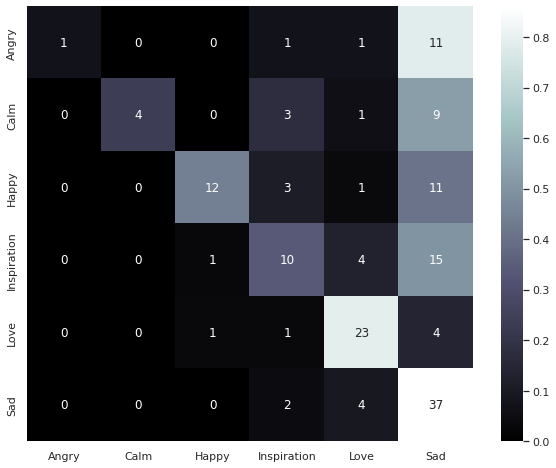

In [70]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Logistic Regression for TF_IDF n-grams

Execution time : 0.400 s
Score : 31.25 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       1.00      0.06      0.11        17
       Happy       1.00      0.19      0.31        27
 Inspiration       0.50      0.13      0.21        30
        Love       0.00      0.00      0.00        29
         Sad       0.28      0.93      0.43        43

    accuracy                           0.31       160
   macro avg       0.46      0.22      0.18       160
weighted avg       0.44      0.31      0.22       160


Confusion Matrix



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Cohen's kappa: 7.23%




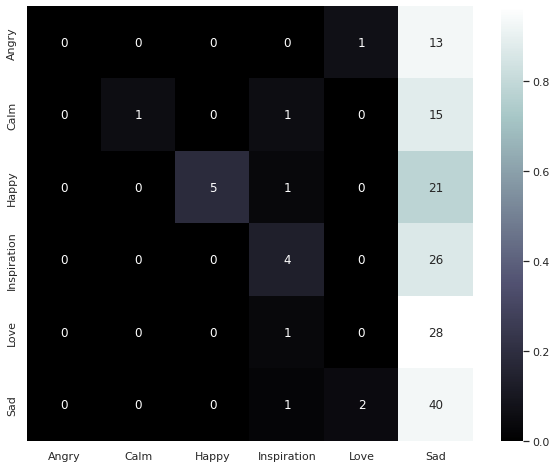

In [71]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Logistic Regression for TF_IDF char n-grams

Execution time : 0.799 s
Score : 51.88 %

Classification Report

              precision    recall  f1-score   support

       Angry       1.00      0.07      0.13        14
        Calm       0.67      0.24      0.35        17
       Happy       0.71      0.56      0.63        27
 Inspiration       0.27      0.20      0.23        30
        Love       0.68      0.72      0.70        29
         Sad       0.46      0.84      0.59        43

    accuracy                           0.52       160
   macro avg       0.63      0.44      0.44       160
weighted avg       0.58      0.52      0.48       160


Confusion Matrix



Cohen's kappa: 38.28%




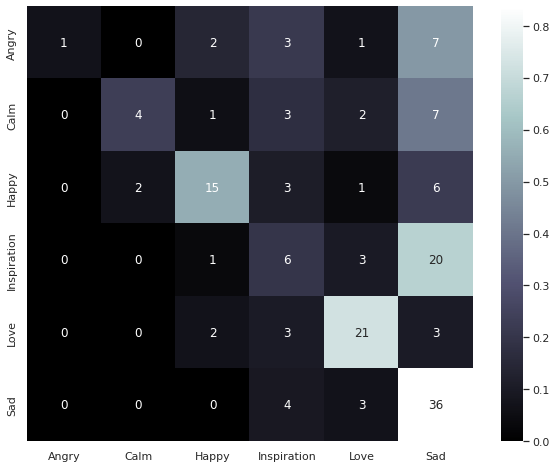

In [72]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF char n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

# SVM


SVM for One-Hot encoding

Execution time : 0.192 s
Score : 41.25 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       1.00      0.12      0.21        17
       Happy       1.00      0.15      0.26        27
 Inspiration       0.50      0.13      0.21        30
        Love       0.67      0.62      0.64        29
         Sad       0.32      0.88      0.47        43

    accuracy                           0.41       160
   macro avg       0.58      0.32      0.30       160
weighted avg       0.58      0.41      0.35       160


Confusion Matrix



Cohen's kappa: 22.15%




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


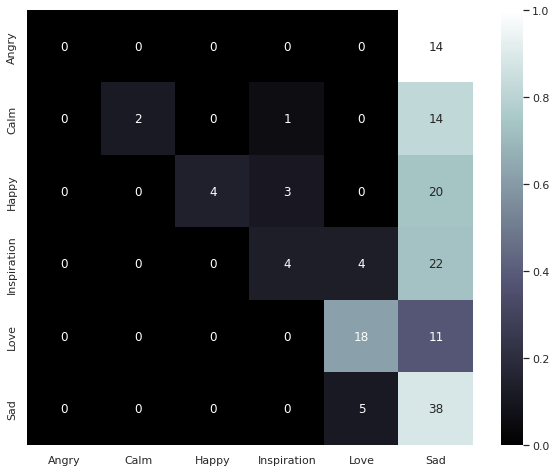

In [73]:
if svm_model:
    print("\nSVM for One-Hot encoding\n")
    metrics_ML(svm.SVC(),  xtrain_count, train_y, xvalid_count, valid_y, gb=False)


SVM for TF_IDF

Execution time : 0.402 s
Score : 43.75 %

Classification Report

              precision    recall  f1-score   support

       Angry       1.00      0.07      0.13        14
        Calm       0.00      0.00      0.00        17
       Happy       1.00      0.26      0.41        27
 Inspiration       0.80      0.13      0.23        30
        Love       0.66      0.66      0.66        29
         Sad       0.33      0.91      0.48        43

    accuracy                           0.44       160
   macro avg       0.63      0.34      0.32       160
weighted avg       0.61      0.44      0.37       160


Confusion Matrix



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Cohen's kappa: 25.51%




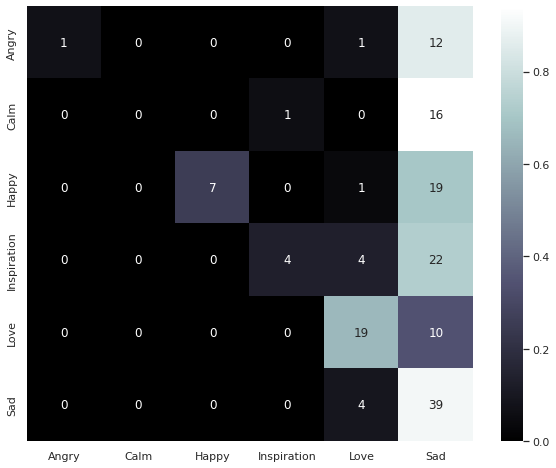

In [74]:
if svm_model:
    print("\nSVM for TF_IDF\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=False)


SVM for TF_IDF n-grams

Execution time : 0.148 s
Score : 30.63 %

Classification Report



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.50      0.12      0.19        17
       Happy       1.00      0.04      0.07        27
 Inspiration       0.75      0.10      0.18        30
        Love       0.00      0.00      0.00        29
         Sad       0.28      1.00      0.44        43

    accuracy                           0.31       160
   macro avg       0.42      0.21      0.15       160
weighted avg       0.44      0.31      0.18       160


Confusion Matrix



Cohen's kappa: 5.99%




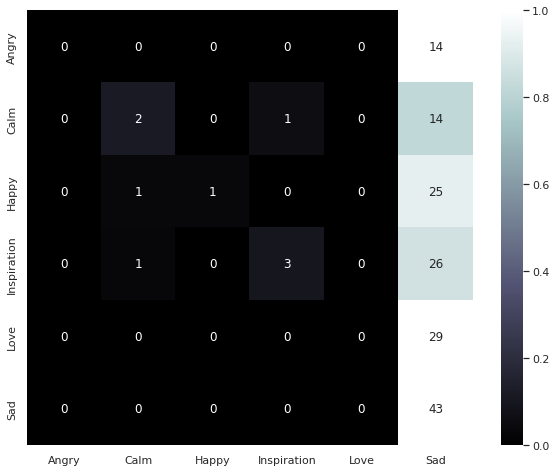

In [75]:
if svm_model:
    print("\nSVM for TF_IDF n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=False)


SVM for TF_IDF char n-grams

Execution time : 1.872 s
Score : 46.25 %

Classification Report

              precision    recall  f1-score   support

       Angry       1.00      0.07      0.13        14
        Calm       1.00      0.12      0.21        17
       Happy       0.81      0.48      0.60        27
 Inspiration       0.33      0.13      0.19        30
        Love       0.67      0.55      0.60        29
         Sad       0.36      0.88      0.51        43

    accuracy                           0.46       160
   macro avg       0.70      0.37      0.38       160
weighted avg       0.61      0.46      0.42       160


Confusion Matrix



Cohen's kappa: 29.61%




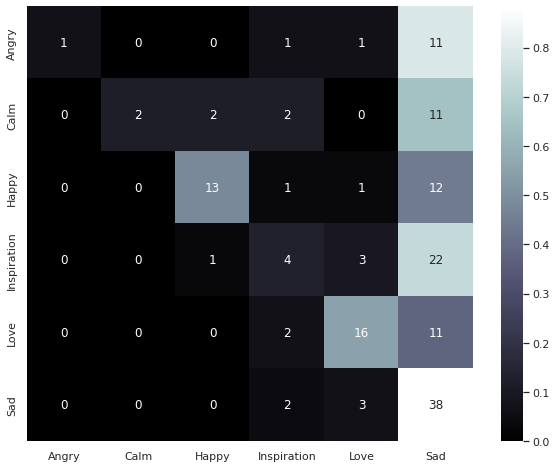

In [76]:
if svm_model:
    print("\nSVM for TF_IDF char n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=False)

# KNN


k-NN for One-Hot encoding

Execution time : 0.001 s
Score : 34.38 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.18      0.71      0.29        17
       Happy       0.86      0.22      0.35        27
 Inspiration       0.50      0.27      0.35        30
        Love       0.40      0.79      0.53        29
         Sad       0.50      0.14      0.22        43

    accuracy                           0.34       160
   macro avg       0.41      0.35      0.29       160
weighted avg       0.47      0.34      0.31       160


Confusion Matrix



Cohen's kappa: 22.28%




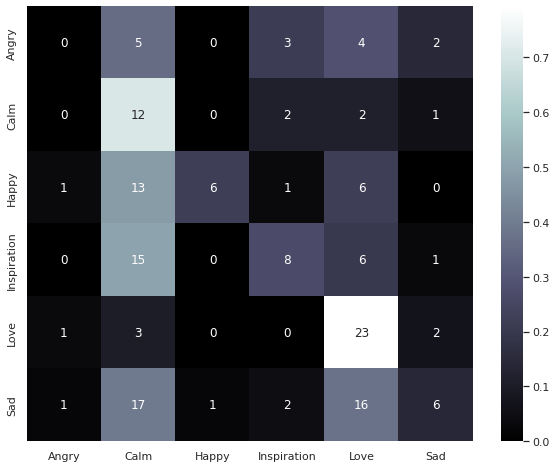

In [81]:
if k_nn_model:
    print("\nk-NN for One-Hot encoding\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_count, train_y, xvalid_count, valid_y, gb=True)


k-NN for TF_IDF

Execution time : 0.001 s
Score : 52.5 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.60      0.21      0.32        14
        Calm       0.57      0.24      0.33        17
       Happy       0.93      0.52      0.67        27
 Inspiration       0.45      0.30      0.36        30
        Love       0.52      0.83      0.64        29
         Sad       0.45      0.70      0.55        43

    accuracy                           0.53       160
   macro avg       0.59      0.47      0.48       160
weighted avg       0.57      0.53      0.51       160


Confusion Matrix



Cohen's kappa: 39.78%




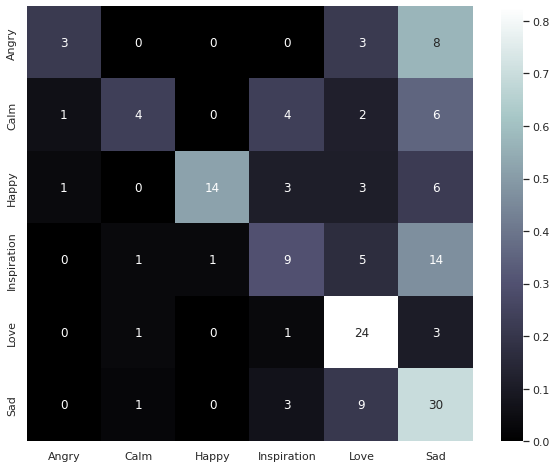

In [82]:
if k_nn_model:
    print("\nk-NN for TF_IDF\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


k-NN for TF_IDF n-grams

Execution time : 0.001 s
Score : 10.62 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.10      0.94      0.18        17
       Happy       1.00      0.04      0.07        27
 Inspiration       0.00      0.00      0.00        30
        Love       0.00      0.00      0.00        29
         Sad       0.00      0.00      0.00        43

    accuracy                           0.11       160
   macro avg       0.18      0.16      0.04       160
weighted avg       0.18      0.11      0.03       160


Confusion Matrix



Cohen's kappa: -0.1%




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


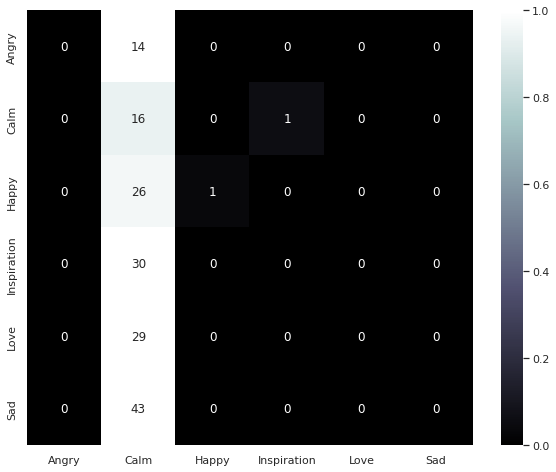

In [83]:
if k_nn_model:
    print("\nk-NN for TF_IDF n-grams\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True) 

#Random Forest


Random Forest for One-Hot encoding

Execution time : 1.584 s
Score : 52.5 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.83      0.36      0.50        14
        Calm       0.47      0.41      0.44        17
       Happy       0.71      0.37      0.49        27
 Inspiration       0.42      0.27      0.33        30
        Love       0.56      0.83      0.67        29
         Sad       0.48      0.70      0.57        43

    accuracy                           0.53       160
   macro avg       0.58      0.49      0.50       160
weighted avg       0.55      0.53      0.51       160


Confusion Matrix



Cohen's kappa: 40.27%




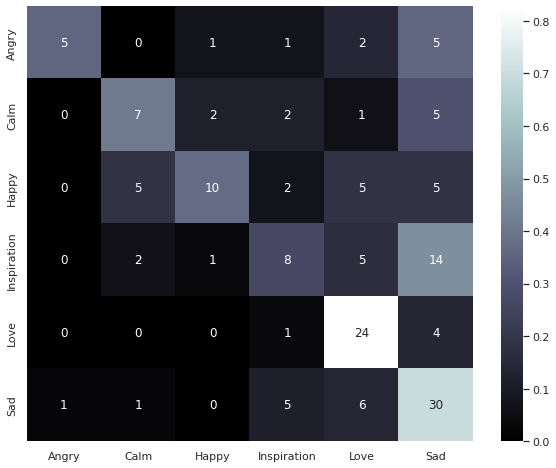

In [87]:
if random_forest:
    print("\nRandom Forest for One-Hot encoding\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_count, train_y, xvalid_count, valid_y, gb=True)


Random Forest for TF_IDF

Execution time : 1.380 s
Score : 56.25 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.83      0.36      0.50        14
        Calm       0.60      0.53      0.56        17
       Happy       0.73      0.41      0.52        27
 Inspiration       0.54      0.47      0.50        30
        Love       0.52      0.76      0.62        29
         Sad       0.52      0.67      0.59        43

    accuracy                           0.56       160
   macro avg       0.62      0.53      0.55       160
weighted avg       0.60      0.56      0.56       160


Confusion Matrix



Cohen's kappa: 45.23%




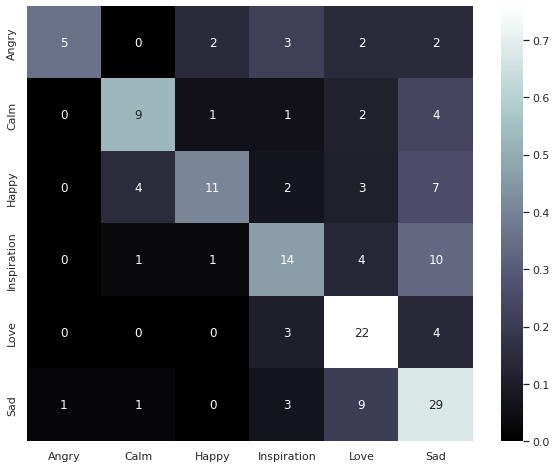

In [85]:
if random_forest:
    print("\nRandom Forest for TF_IDF\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Random Forest for TF_IDF n-grams

Execution time : 2.811 s
Score : 30.63 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.17      0.88      0.29        17
       Happy       0.33      0.22      0.27        27
 Inspiration       0.62      0.33      0.43        30
        Love       0.50      0.24      0.33        29
         Sad       0.48      0.26      0.33        43

    accuracy                           0.31       160
   macro avg       0.35      0.32      0.27       160
weighted avg       0.41      0.31      0.31       160


Confusion Matrix



Cohen's kappa: 18.27%




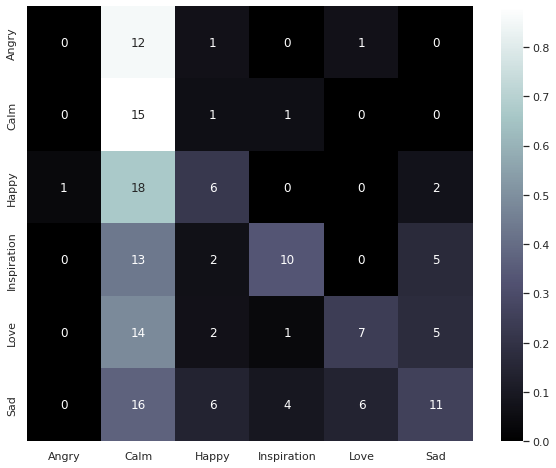

In [86]:
if random_forest:
    print("\nRandom Forest for TF_IDF n-grams\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)

#Stochastic Descent


Stochastic Gradient Descent with early stopping for One-Hot encoding

Early Stopping : 10 iterations without change
Execution time : 0.252 s
Score : 52.5 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.28      0.36      0.31        14
        Calm       0.36      0.24      0.29        17
       Happy       0.70      0.52      0.60        27
 Inspiration       0.43      0.43      0.43        30
        Love       0.55      0.59      0.57        29
         Sad       0.62      0.72      0.67        43

    accuracy                           0.53       160
   macro avg       0.49      0.48      0.48       160
weighted avg       0.53      0.53      0.52       160


Confusion Matrix



Cohen's kappa: 41.18%




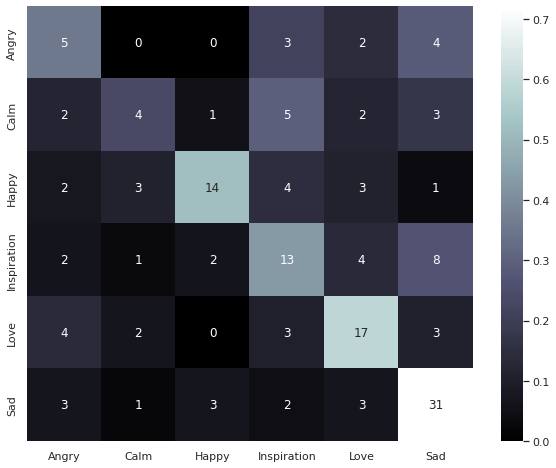

In [88]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for One-Hot encoding\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),  xtrain_count, train_y, xvalid_count, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF

Early Stopping : 10 iterations without change
Execution time : 0.111 s
Score : 53.12 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.83      0.36      0.50        14
        Calm       0.26      0.41      0.32        17
       Happy       0.64      0.59      0.62        27
 Inspiration       0.48      0.40      0.44        30
        Love       0.56      0.66      0.60        29
         Sad       0.60      0.60      0.60        43

    accuracy                           0.53       160
   macro avg       0.56      0.50      0.51       160
weighted avg       0.56      0.53      0.54       160


Confusion Matrix



Cohen's kappa: 42.3%




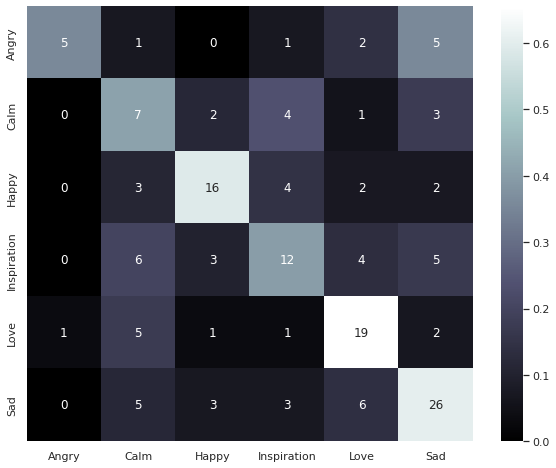

In [89]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)

#Gradient Boosting


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 2.143 s
Score : 45.0 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.57      0.29      0.38        14
        Calm       0.00      0.00      0.00        17
       Happy       0.73      0.41      0.52        27
 Inspiration       0.31      0.17      0.22        30
        Love       0.51      0.76      0.61        29
         Sad       0.41      0.70      0.52        43

    accuracy                           0.45       160
   macro avg       0.42      0.39      0.38       160
weighted avg       0.44      0.45      0.41       160


Confusion Matrix



Cohen's kappa: 30.05%




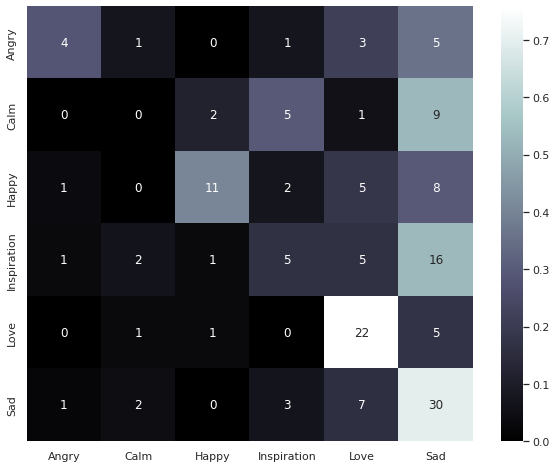

In [90]:

if gradient_boosting:
    print("\nGradient Boosting with early stopping for Count Vectors\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_count, train_y, xvalid_count, valid_y, gb=True)


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 1.470 s
Score : 50.0 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.57      0.29      0.38        14
        Calm       0.50      0.24      0.32        17
       Happy       0.79      0.41      0.54        27
 Inspiration       0.42      0.27      0.33        30
        Love       0.57      0.72      0.64        29
         Sad       0.43      0.74      0.54        43

    accuracy                           0.50       160
   macro avg       0.55      0.44      0.46       160
weighted avg       0.53      0.50      0.48       160


Confusion Matrix



Cohen's kappa: 36.38%




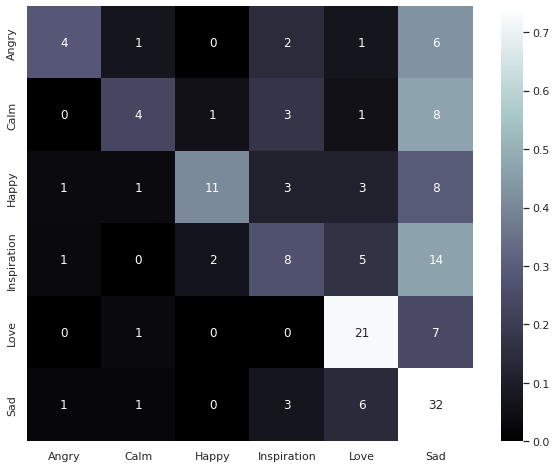

In [91]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 0.970 s
Score : 28.12 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
        Calm       0.00      0.00      0.00        17
       Happy       0.00      0.00      0.00        27
 Inspiration       0.60      0.10      0.17        30
        Love       0.35      0.24      0.29        29
         Sad       0.27      0.81      0.40        43

    accuracy                           0.28       160
   macro avg       0.20      0.19      0.14       160
weighted avg       0.25      0.28      0.19       160


Confusion Matrix



Cohen's kappa: 3.86%




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


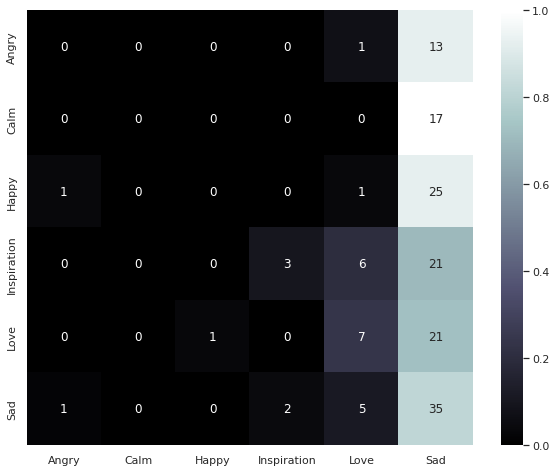

In [92]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 7.131 s
Score : 39.38 %

Classification Report

              precision    recall  f1-score   support

       Angry       0.45      0.36      0.40        14
        Calm       0.25      0.12      0.16        17
       Happy       0.37      0.26      0.30        27
 Inspiration       0.26      0.23      0.25        30
        Love       0.61      0.69      0.65        29
         Sad       0.35      0.51      0.42        43

    accuracy                           0.39       160
   macro avg       0.38      0.36      0.36       160
weighted avg       0.38      0.39      0.38       160


Confusion Matrix



Cohen's kappa: 23.79%




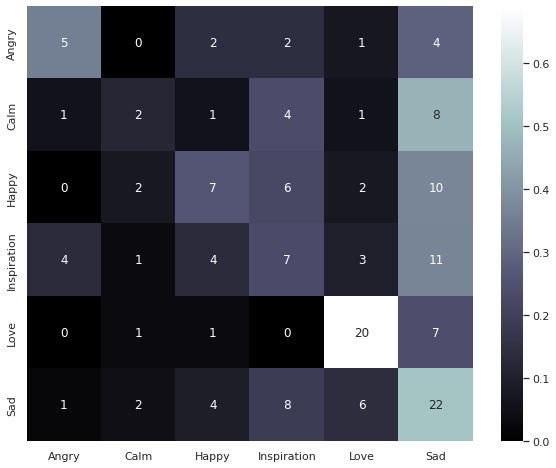

In [93]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

#XGBoost Classifier

In [94]:
def xgb_model(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

For count vectors


XGBoost for Count Vectors


Accuracy: 51.25%

Classification Report

              precision    recall  f1-score   support

       Angry       0.75      0.43      0.55        14
        Calm       0.38      0.35      0.36        17
       Happy       0.61      0.41      0.49        27
 Inspiration       0.30      0.23      0.26        30
        Love       0.51      0.76      0.61        29
         Sad       0.58      0.70      0.63        43

    accuracy                           0.51       160
   macro avg       0.52      0.48      0.48       160
weighted avg       0.51      0.51      0.50       160


Confusion Matrix



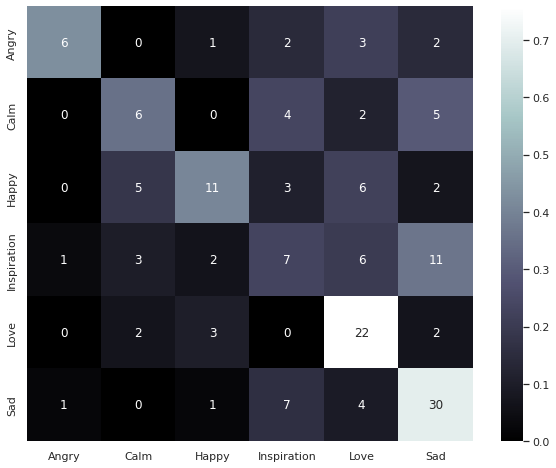

In [97]:
if xgboost_classifier:
    print("\nXGBoost for Count Vectors\n")
    xgbs, pred, accuracy = xgb_model(xtrain_count, train_y, xvalid_count, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)


XGBoost for TF_IDF


Accuracy: 51.25%

Classification Report

              precision    recall  f1-score   support

       Angry       0.67      0.29      0.40        14
        Calm       0.60      0.35      0.44        17
       Happy       0.67      0.44      0.53        27
 Inspiration       0.36      0.30      0.33        30
        Love       0.55      0.76      0.64        29
         Sad       0.48      0.67      0.56        43

    accuracy                           0.51       160
   macro avg       0.55      0.47      0.48       160
weighted avg       0.53      0.51      0.50       160


Confusion Matrix



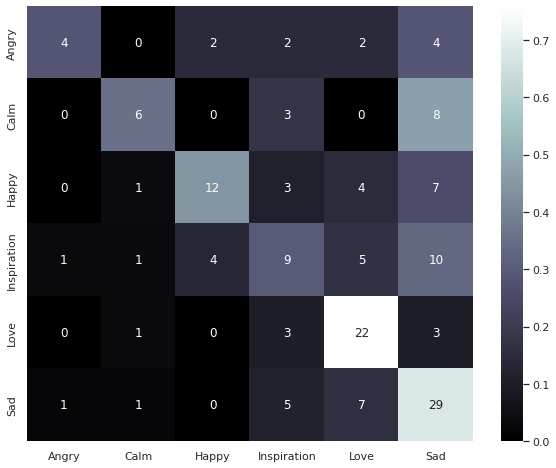

In [100]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf, train_y, xvalid_tfidf, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)


XGBoost for Word Embeddings


Accuracy: 33.12%

Classification Report

              precision    recall  f1-score   support

       Angry       0.50      0.07      0.12        14
        Calm       0.46      0.35      0.40        17
       Happy       0.24      0.15      0.18        27
 Inspiration       0.29      0.20      0.24        30
        Love       0.39      0.24      0.30        29
         Sad       0.33      0.67      0.44        43

    accuracy                           0.33       160
   macro avg       0.37      0.28      0.28       160
weighted avg       0.34      0.33      0.30       160


Confusion Matrix



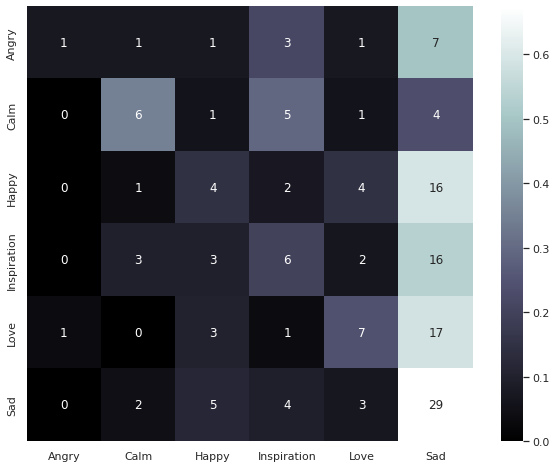

In [116]:
if xgboost_classifier:
    print("\nXGBoost for Word Embeddings\n")
    xgbs, pred, accuracy = xgb_model(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

#Deep Learning
Cohen’s kappa
The function cohen_kappa_score computes Cohen’s kappa statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

**Balanced Accuracy**
Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

Early Stopping, Model saving, Class weight configuration

In [117]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [118]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

Shallow Neural Networks

In [122]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=6 else len(label), activation='sigmoid' if len(label)<=6 else "softmax")])

    if len(label)==6:
        model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [123]:
if shallow_network:
    model_shallow = shallow_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          56128     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 56,145
Trainable params: 56,145
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
if shallow_network:
    history = model_shallow.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0957 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172


**Deep Neural Network**

In [125]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=6 else len(label), activation='sigmoid' if len(label)<=6 else "softmax")])

    if len(label)==6:
        model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [126]:
if deep_nn:
    model = deep_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         350800    
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 352,433
Trainable params: 352,433
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 35ms/step - loss: 0.0000e+00 - accuracy: 0.1055 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 2/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 3/1000
16/16 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172
Epoch 4/1000
16/16 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - val_loss: 0.0000e+00 - val_accuracy: 0.1172


[link](https://github.com/supuni9622/Text-classification/blob/master/Text_Classification.ipynb)